In [11]:
%load_ext autoreload
%autoreload 2
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
from os.path import join as oj
import seaborn as sns
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
results_dir = '/accounts/projects/vision/chandan/class-weight-uncertainty/results/pmlb'
os.makedirs(results_dir, exist_ok=True)
# depending on how much is saved, this may take a while
# out_dir = '/scratch/users/vision/chandan/pacmed/with_flips_bugs/logistic'
# out_dir = '/scratch/users/vision/chandan/pacmed/with_flips_bugs/rf'
# out_dir = '/scratch/users/vision/chandan/pacmed/with_flips_bugs/gb'
# out_dir = '/scratch/users/vision/chandan/pacmed/with_flips_bugs/mlp_sweep'
out_dir = '/scratch/users/vision/chandan/pacmed/no_flips/mlp2'
fnames = sorted([fname for fname in os.listdir(out_dir)])
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames)]
results = pd.concat(results_list, axis=1).T.infer_objects()

100%|██████████| 94/94 [00:00<00:00, 309.26it/s]


**note - cw is class-weight an pe is predictive-entropy**

In [13]:
# results.describe()

# compare statistics

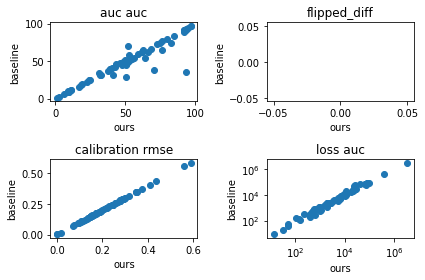

In [14]:
r = results

R, C = 2, 2
plt.subplot(R, C, 1)
plt.title('auc auc')
plt.plot(r.cw_auc_auc_test, r.pe_auc_auc_test, 'o')
plt.xlabel('ours')
plt.ylabel('baseline')


plt.subplot(R, C, 2)
plt.title('flipped_diff')
plt.plot(r.cw_flipped_diff_test, r.pe_flipped_diff_test, 'o')
plt.xlabel('ours')
plt.ylabel('baseline')

plt.subplot(R, C, 3)
plt.title('calibration rmse')
plt.plot(r.cw_calibration_rmse_test, r.pe_calibration_rmse_test, 'o')
plt.xlabel('ours')
plt.ylabel('baseline')

plt.subplot(R, C, 4)
plt.title('loss auc')
plt.plot(r.cw_loss_auc_test, r.pe_loss_auc_test, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('ours')
plt.ylabel('baseline')

plt.tight_layout()
plt.savefig(oj(results_dir, 'pmlb_results.pdf'))
plt.show()